In [1]:
import os
from glob import glob

import fathon
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dynamic_properties as dynprop
from fathon import fathonUtils as fu
from hurst import compute_Hc
from scipy.stats import chi2
from utils import RESULTS_ROOT
import logging

logging.basicConfig(level=logging.INFO)

FOLDERS = [
    "20210916_4microstates_2.0-20.0Hz_EC_subjectwise",
    "20210917_4PCA_2.0-20.0Hz_EC_subjectwise",
    "20211025_4hmm_2.0-20.0Hz_EC_subjectwise",
]

fold_names = [
    "-".join(fold.split("_")[1:3]).replace("-2.0-20.0Hz", "") for fold in FOLDERS
]

In [2]:
# subjects intersection
all_sets = []
for fold in FOLDERS:
    files = sorted(glob(f"{os.path.join(RESULTS_ROOT, fold)}/sub*.npz"))
    all_sets.append(set([file.split("/")[-1].split("_")[0] for file in files]))
subjects_intersection = set.intersection(*all_sets)

In [3]:
all_segmentations = []
all_segmentations_subjectwise = []
for fold in FOLDERS:
    concat_segmentations = []
    for file in sorted(glob(f"{os.path.join(RESULTS_ROOT, fold)}/sub*.npz")):
        subj = file.split("/")[-1].split("_")[0]
        if subj not in subjects_intersection:
            continue
        loaded = np.load(file)
        concat_segmentations.append(loaded["latent_segmentation"])
    all_segmentations_subjectwise.append(concat_segmentations)
    concat = np.concatenate(concat_segmentations)
    all_segmentations.append(concat)

all_segmentations = np.vstack(all_segmentations)

In [4]:
len(all_segmentations_subjectwise), len(
    all_segmentations_subjectwise[0]
), all_segmentations_subjectwise[0][0].shape

(3, 202, (119345,))

In [5]:
np.array(all_segmentations_subjectwise).shape

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(3, 202)

In [6]:
def p_empirical(data, n_clusters):
    """Empirical symbol distribution
    Args:
        data: numpy.array, size = length of microstate sequence
        n_clusters: number of microstate clusters
    Returns:
        p: empirical distribution
    """
    p = np.zeros(n_clusters)
    n = len(data)
    for i in range(n):
        p[data[i]] += 1.0
    p /= n
    return p


def T_empirical(data, n_clusters):
    """Empirical transition matrix
    Args:
        data: numpy.array, size = length of microstate sequence
        n_clusters: number of microstate clusters
    Returns:
        T: empirical transition matrix
    """
    T = np.zeros((n_clusters, n_clusters))
    n = len(data)
    for i in range(n - 1):
        T[data[i], data[i + 1]] += 1.0
    p_row = np.sum(T, axis=1)
    for i in range(n_clusters):
        if p_row[i] != 0.0:
            for j in range(n_clusters):
                T[i, j] /= p_row[i]  # normalize row sums to 1.0
    return T


def p_equilibrium(T):
    """
    get equilibrium distribution from transition matrix:
    lambda = 1 - (left) eigenvector
    """
    evals, evecs = np.linalg.eig(T.transpose())
    i = np.where(np.isclose(evals, 1.0, atol=1e-6))[0][0]  # locate max eigenval.
    p_eq = np.abs(evecs[:, i])  # make eigenvec. to max. eigenval. non-negative
    p_eq /= p_eq.sum()  # normalized eigenvec. to max. eigenval.
    return p_eq  # stationary distribution


def max_entropy(n_clusters):
    """Maximum Shannon entropy of a sequence with n_clusters
    Args:
        n_clusters: number of microstate clusters
    Returns:
        h_max: maximum Shannon entropy
    """
    h_max = np.log(float(n_clusters))
    return h_max


def mixing_time(X, ns):
    """
    Relaxation time, inverse of spectral gap
    Arguments:
        X: microstate label sequence
        ns: number of unique labels
    """
    T_hat = T_empirical(X, ns)  # transition matrix
    ev = np.linalg.eigvals(T_hat)
    # ev = np.real_if_close(ev)
    ev = np.real(ev)
    ev.sort()  # ascending
    ev2 = np.flipud(ev)  # descending
    # print("ordered eigenvalues: {:s}".format|(str(ev2)))
    sg = ev2[0] - ev2[1]  # spectral gap
    T_mix = 1.0 / sg  # mixing time
    return T_mix


def H_1(x, ns):
    """Shannon entropy of the symbolic sequence x with ns symbols.
    Args:
        x: symbolic sequence, symbols = [0, 1, 2, ...]
        ns: number of symbols
    Returns:
        h: Shannon entropy of x
    """

    n = len(x)
    p = np.zeros(ns)  # symbol distribution
    for t in range(n):
        p[x[t]] += 1.0
    p /= n
    h = -np.sum(p[p > 0] * np.log(p[p > 0]))
    return h


def H_2(x, y, ns):
    """Joint Shannon entropy of the symbolic sequences X, Y with ns symbols.
    Args:
        x, y: symbolic sequences, symbols = [0, 1, 2, ...]
        ns: number of symbols
    Returns:
        h: Shannon entropy of x
    """

    if len(x) != len(y):
        print("H_2 warning: sequences of different lengths, using the shorter...")
    n = min([len(x), len(y)])
    p = np.zeros((ns, ns))  # joint distribution
    for t in range(n):
        p[x[t], y[t]] += 1.0
    p /= n
    h = -np.sum(p[p > 0] * np.log(p[p > 0]))
    return h


def H_k(x, ns, k):
    """Shannon's joint entropy from x[n+p:n-m]
    x: symbolic time series
    ns: number of symbols
    k: length of k-history
    """

    N = len(x)
    f = np.zeros(tuple(k * [ns]))
    for t in range(N - k):
        f[tuple(x[t : t + k])] += 1.0
    f /= N - k  # normalize distribution
    hk = -np.sum(f[f > 0] * np.log(f[f > 0]))
    # m = np.sum(f>0)
    # hk = hk + (m-1)/(2*N) # Miller-Madow bias correction
    return hk


def excess_entropy_rate(x, ns, kmax, doplot=False):
    # y = ax+b: line fit to joint entropy for range of histories k
    # a = entropy rate (slope)
    # b = excess entropy (intersect.)
    h_ = np.zeros(kmax)
    for k in range(kmax):
        h_[k] = H_k(x, ns, k + 1)
    ks = np.arange(1, kmax + 1)
    a, b = np.polyfit(ks, h_, 1)
    # --- Figure ---
    if doplot:
        plt.figure(figsize=(6, 6))
        plt.plot(ks, h_, "-sk")
        plt.plot(ks, a * ks + b, "-b")
        plt.xlabel("k")
        plt.ylabel("$H_k$")
        plt.title("Entropy rate")
        plt.tight_layout()
        plt.show()
    return (a, b)


def mc_entropy_rate(p, T):
    """Markov chain entropy rate.
    - \sum_i sum_j p_i T_ij log(T_ij)
    """
    h = 0.0
    for i, j in np.ndindex(T.shape):
        if T[i, j] > 0:
            h -= p[i] * T[i, j] * np.log(T[i, j])
    return h


def mutinf(x, ns, lmax):
    """Time-lagged mutual information of symbolic sequence x with
    ns different symbols, up to maximum lag lmax.
    *** Symbols must be 0, 1, 2, ... to use as indices directly! ***
    Args:
        x: symbolic sequence, symbols = [0, 1, 2, ...]
        ns: number of symbols
        lmax: maximum time lag
    Returns:
        mi: time-lagged mutual information
    """

    n = len(x)
    mi = np.zeros(lmax)
    for l in range(lmax):
        if (l + 1) % 10 == 0:
            print(f"mutual information lag: {l+1:d}\r", end="")
            # sys.stdout.write(s)
            # sys.stdout.flush()
        nmax = n - l
        h1 = H_1(x[:nmax], ns)
        h2 = H_1(x[l : l + nmax], ns)
        h12 = H_2(x[:nmax], x[l : l + nmax], ns)
        mi[l] = h1 + h2 - h12
    print("")
    return mi


def locmax(x):
    """Get local maxima of 1D-array
    Args:
        x: numeric sequence
    Returns:
        m: list, 1D-indices of local maxima
    """

    dx = np.diff(x)  # discrete 1st derivative
    zc = np.diff(np.sign(dx))  # zero-crossings of dx
    m = 1 + np.where(zc == -2)[0]  # indices of local max.
    return m


def aif_peak1(mi, fs, doplot=False):
    """compute time-lagged mut. inf. (AIF) and 1st peak."""
    dt = 1000.0 / fs  # sampling interval [ms]
    mi_filt = np.convolve(mi, np.ones(3) / 3.0, mode="same")
    # mi_filt = np.convolve(mi, np.ones(5)/5., mode='same')
    mx0 = 8  # 8
    jmax = mx0 + locmax(mi_filt[mx0:])[0]
    mx_mi = dt * jmax
    if doplot:
        offset = 5
        tmax = 100
        fig = plt.figure(1, figsize=(22, 4))
        t = dt * np.arange(tmax)
        plt.plot(t[offset:tmax], mi[offset:tmax], "-ok", label="AIF")
        plt.plot(t[offset:tmax], mi_filt[offset:tmax], "-b", label="smoothed AIF")
        plt.plot(mx_mi, mi[jmax], "or", markersize=15, label="peak-1")
        plt.xlabel("time lag [ms]")
        plt.ylabel("mut. inf. [bits]")
        plt.legend(loc=0)
        # plt.title("mutual information of map sequence")
        # plt.title(s, fontsize=16, fontweight='bold')
        plt.show()

    return jmax, mx_mi


def conditionalHomogeneityTest(X, ns, l, alpha, verbose=True):
    """Test conditional homogeneity of non-overlapping blocks of
    length l of symbolic sequence X with ns symbols
    cf. Kullback, Technometrics (1962), Table 9.1.
    Args:
        x: symbolic sequence, symbols = [0, 1, 2, ...]
        ns: number of symbols
        l: split x into non-overlapping blocks of size l
        alpha: significance level
    Returns:
        p: p-value of the Chi2 test for independence
    """

    if verbose:
        print("\nCONDITIONAL HOMOGENEITY (three-way table):")
    n = len(X)
    r = int(np.floor(float(n) / float(l)))  # number of blocks
    nl = r * l
    if verbose:
        print("Split data in r = {:d} blocks of length {:d}.".format(r, l))
    f_ijk = np.zeros((r, ns, ns))
    f_ij = np.zeros((r, ns))
    f_jk = np.zeros((ns, ns))
    f_i = np.zeros(r)
    f_j = np.zeros(ns)

    # calculate f_ijk (time / block dep. transition matrix)
    for i in range(r):  # block index
        for ii in range(l - 1):  # pos. inside the current block
            j = X[i * l + ii]
            k = X[i * l + ii + 1]
            f_ijk[i, j, k] += 1.0
            f_ij[i, j] += 1.0
            f_jk[j, k] += 1.0
            f_i[i] += 1.0
            f_j[j] += 1.0

    # conditional homogeneity (Markovianity stationarity)
    T = 0.0
    for i, j, k in np.ndindex(f_ijk.shape):
        # conditional homogeneity
        f = f_ijk[i, j, k] * f_j[j] * f_ij[i, j] * f_jk[j, k]
        if f > 0:
            num_ = f_ijk[i, j, k] * f_j[j]
            den_ = f_ij[i, j] * f_jk[j, k]
            T += f_ijk[i, j, k] * np.log(num_ / den_)
    T *= 2.0
    df = (r - 1) * (ns - 1) * ns
    # p = chi2test(T, df, alpha)
    p = chi2.sf(T, df, loc=0, scale=1)
    if verbose:
        print(f"p: {p:.2e} | t: {T:.3f} | df: {df:.1f}")
    return p


def testMarkov0(x, ns, alpha, verbose=True):
    """Test zero-order Markovianity of symbolic sequence x with ns symbols.
    Null hypothesis: zero-order MC (iid) <=>
    p(X[t]), p(X[t+1]) independent
    cf. Kullback, Technometrics (1962)
    Args:
        x: symbolic sequence, symbols = [0, 1, 2, ...]
        ns: number of symbols
        alpha: significance level
    Returns:
        p: p-value of the Chi2 test for independence
    """

    if verbose:
        print("ZERO-ORDER MARKOVIANITY:")
    n = len(x)
    f_ij = np.zeros((ns, ns))
    f_i = np.zeros(ns)
    f_j = np.zeros(ns)
    # calculate f_ij p( x[t]=i, p( x[t+1]=j ) )
    for t in range(n - 1):
        i = x[t]
        j = x[t + 1]
        f_ij[i, j] += 1.0
        f_i[i] += 1.0
        f_j[j] += 1.0
    T = 0.0  # statistic
    for i, j in np.ndindex(f_ij.shape):
        f = f_ij[i, j] * f_i[i] * f_j[j]
        if f > 0:
            num_ = n * f_ij[i, j]
            den_ = f_i[i] * f_j[j]
            T += f_ij[i, j] * np.log(num_ / den_)
    T *= 2.0
    df = (ns - 1.0) * (ns - 1.0)
    # p = chi2test(T, df, alpha)
    p = chi2.sf(T, df, loc=0, scale=1)
    if verbose:
        print(f"p: {p:.2e} | t: {T:.3f} | df: {df:.1f}")
    return p


def testMarkov1(X, ns, alpha, verbose=True):
    """Test first-order Markovianity of symbolic sequence X with ns symbols.
    Null hypothesis:
    first-order MC <=>
    p(X[t+1] | X[t]) = p(X[t+1] | X[t], X[t-1])
    cf. Kullback, Technometrics (1962), Tables 8.1, 8.2, 8.6.
    Args:
        x: symbolic sequence, symbols = [0, 1, 2, ...]
        ns: number of symbols
        alpha: significance level
    Returns:
        p: p-value of the Chi2 test for independence
    """

    if verbose:
        print("\nFIRST-ORDER MARKOVIANITY:")
    n = len(X)
    f_ijk = np.zeros((ns, ns, ns))
    f_ij = np.zeros((ns, ns))
    f_jk = np.zeros((ns, ns))
    f_j = np.zeros(ns)
    for t in range(n - 2):
        i = X[t]
        j = X[t + 1]
        k = X[t + 2]
        f_ijk[i, j, k] += 1.0
        f_ij[i, j] += 1.0
        f_jk[j, k] += 1.0
        f_j[j] += 1.0
    T = 0.0
    for i, j, k in np.ndindex(f_ijk.shape):
        f = f_ijk[i][j][k] * f_j[j] * f_ij[i][j] * f_jk[j][k]
        if f > 0:
            num_ = f_ijk[i, j, k] * f_j[j]
            den_ = f_ij[i, j] * f_jk[j, k]
            T += f_ijk[i, j, k] * np.log(num_ / den_)
    T *= 2.0
    df = ns * (ns - 1) * (ns - 1)
    # p = chi2test(T, df, alpha)
    p = chi2.sf(T, df, loc=0, scale=1)
    if verbose:
        print(f"p: {p:.2e} | t: {T:.3f} | df: {df:.1f}")
    return p


def testMarkov2(X, ns, alpha, verbose=True):
    """Test second-order Markovianity of symbolic sequence X with ns symbols.
    Null hypothesis:
    first-order MC <=>
    p(X[t+1] | X[t], X[t-1]) = p(X[t+1] | X[t], X[t-1], X[t-2])
    cf. Kullback, Technometrics (1962), Table 10.2.
    Args:
        x: symbolic sequence, symbols = [0, 1, 2, ...]
        ns: number of symbols
        alpha: significance level
    Returns:
        p: p-value of the Chi2 test for independence
    """

    if verbose:
        print("\nSECOND-ORDER MARKOVIANITY:")
    n = len(X)
    f_ijkl = np.zeros((ns, ns, ns, ns))
    f_ijk = np.zeros((ns, ns, ns))
    f_jkl = np.zeros((ns, ns, ns))
    f_jk = np.zeros((ns, ns))
    for t in range(n - 3):
        i = X[t]
        j = X[t + 1]
        k = X[t + 2]
        l = X[t + 3]
        f_ijkl[i, j, k, l] += 1.0
        f_ijk[i, j, k] += 1.0
        f_jkl[j, k, l] += 1.0
        f_jk[j, k] += 1.0
    T = 0.0
    for i, j, k, l in np.ndindex(f_ijkl.shape):
        f = f_ijkl[i, j, k, l] * f_ijk[i, j, k] * f_jkl[j, k, l] * f_jk[j, k]
        if f > 0:
            num_ = f_ijkl[i, j, k, l] * f_jk[j, k]
            den_ = f_ijk[i, j, k] * f_jkl[j, k, l]
            T += f_ijkl[i, j, k, l] * np.log(num_ / den_)
    T *= 2.0
    df = ns * ns * (ns - 1) * (ns - 1)
    # p = chi2test(T, df, alpha)
    p = chi2.sf(T, df, loc=0, scale=1)
    if verbose:
        print(f"p: {p:.2e} | t: {T:.3f} | df: {df:.1f}")
    return p

In [7]:
p = p_empirical(all_segmentations_subjectwise[0][0], n_clusters=4)
print(p)

p1 = dynprop.empirical_distribution(all_segmentations_subjectwise[0][0], n_states=4)
print(p1)

[0.27568813 0.2588462  0.26418367 0.201282  ]
[0.27568813 0.2588462  0.26418367 0.201282  ]


In [8]:
T = T_empirical(all_segmentations_subjectwise[0][0], n_clusters=4)
T

array([[0.92824144, 0.02650295, 0.02683727, 0.01841833],
       [0.02615564, 0.92800725, 0.02560533, 0.02023178],
       [0.02892575, 0.02343874, 0.92540201, 0.0222335 ],
       [0.02664335, 0.02551934, 0.0282253 , 0.91961201]])

In [9]:
print(p_equilibrium(T))
print(dynprop.equilibrium_distribution(T))

[0.27560532 0.25884749 0.26418705 0.20136014]
[0.27560532 0.25884749 0.26418705 0.20136014]


In [10]:
print(max_entropy(4), H_1(all_segmentations_subjectwise[0][0], 4))
print(dynprop.max_entropy(4, log2=False), dynprop.H_1(all_segmentations_subjectwise[0][0], 4, log2=False))

1.3862943611198906 1.3793786461243605
1.3862943611198906 1.3793786461243605


In [11]:
print(mixing_time(all_segmentations_subjectwise[0][0], 4))
print(dynprop.mixing_time(T))

10.236559781962528
10.236559781962528


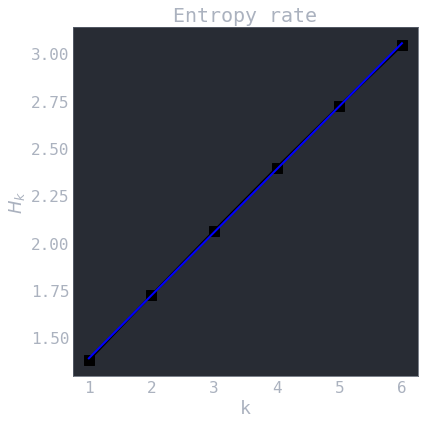

0.3326668538499432 0.3456566077730264 1.0578318059934286
0.3326668538499432 0.3456566077730264 1.0578318059934286


In [12]:
kmax = 6
h_rate, h_exess = excess_entropy_rate(
    all_segmentations_subjectwise[0][0], 4, kmax, doplot=True
)
h_mc = mc_entropy_rate(p, T)
print(h_rate, h_mc, h_exess)

a, b = dynprop.excess_entropy_rate(all_segmentations_subjectwise[0][0], 4, kmax, False)
c = dynprop.markov_chain_entropy_rate(p, T, False)

print(a, c, b)

mutual information lag: 100
29 116.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.32it/s]

(29, 116.0)


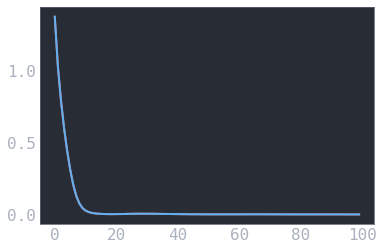

In [13]:
l_max = 100
n_mc = 10
aif = mutinf(all_segmentations_subjectwise[0][0], 4, l_max)
jmax, mx_mi = aif_peak1(aif, 250.0, doplot=False)
print(jmax, mx_mi)

aif1 = dynprop.lagged_mutual_information(all_segmentations_subjectwise[0][0], 4, l_max, False)
print(dynprop.find_1st_aif_peak(aif1, 250.0))

plt.plot(aif)
plt.plot(aif1)


In [14]:
alpha = 0.01

m0 = testMarkov0(all_segmentations_subjectwise[0][0], 4, alpha)
m1 = testMarkov1(all_segmentations_subjectwise[0][0], 4, alpha)
m2 = testMarkov2(all_segmentations_subjectwise[0][0], 4, alpha)

print(m0, m1, m2)

ZERO-ORDER MARKOVIANITY:
p: 0.00e+00 | t: 246739.272 | df: 9.0

FIRST-ORDER MARKOVIANITY:
p: 6.07e-277 | t: 1428.486 | df: 36.0

SECOND-ORDER MARKOVIANITY:
p: 7.16e-235 | t: 1554.152 | df: 144.0
0.0 6.065673648228919e-277 7.162446468928586e-235


In [15]:
m0 = dynprop.test_markovianity_nth_order(all_segmentations_subjectwise[0][0], 4, order=0, log2=False, detailed=True)
m1 = dynprop.test_markovianity_nth_order(all_segmentations_subjectwise[0][0], 4, order=1, log2=False, detailed=True)
m2 = dynprop.test_markovianity_nth_order(all_segmentations_subjectwise[0][0], 4, order=2, log2=False, detailed=True)

print(m0, m1, m2)

INFO:root:p-value: 0.00e+00 | t: 246739.272 | df: 9.0
INFO:root:p-value: 6.07e-277 | t: 1428.486 | df: 36.0
INFO:root:p-value: 7.16e-235 | t: 1554.152 | df: 144.0


(0.0, True, 246739.27225846564, 9.0) (6.065673648228919e-277, True, 1428.4864121537398, 36.0) (7.162446468928586e-235, True, 1554.1515693304789, 144.0)


In [16]:
alpha = 0.01
for L in [500, 1000, 2500]:
    p3 = conditionalHomogeneityTest(all_segmentations_subjectwise[0][0], 4, L, alpha)
    p4 = dynprop.test_stationarity_conditional_homogeneity(all_segmentations_subjectwise[0][0], 4, L, alpha, True)
    print(L)
    print(p3)
    print(p4)


CONDITIONAL HOMOGENEITY (three-way table):
Split data in r = 238 blocks of length 500.
p: 4.33e-01 | t: 2856.049 | df: 2844.0


INFO:root:p-value: 4.33e-01 | t: 2856.049 | df: 2844.0


500
0.4331444406196716
(0.4331444406196716, False, 2856.0491186661934, 2844)

CONDITIONAL HOMOGENEITY (three-way table):
Split data in r = 119 blocks of length 1000.
p: 5.29e-01 | t: 1411.482 | df: 1416.0


INFO:root:p-value: 5.29e-01 | t: 1411.482 | df: 1416.0


1000
0.5288798660038978
(0.5288798660038978, False, 1411.4821729356245, 1416)

CONDITIONAL HOMOGENEITY (three-way table):
Split data in r = 47 blocks of length 2500.
p: 7.19e-01 | t: 532.305 | df: 552.0


INFO:root:p-value: 7.19e-01 | t: 532.305 | df: 552.0


2500
0.7189851781830519
(0.7189851781830519, False, 532.3048103442165, 552)


In [ ]:
pydfa = fathon.DFA(all_segmentations_subjectwise[0][0])

winSizes = fu.linRangeByStep(int(0.256 / dt), int(16.0 / dt))
revSeg = True
polOrd = 5

n, F = pydfa.computeFlucVec(winSizes, revSeg=revSeg, polOrd=polOrd)
print(n, F)
H, H_intercept = pydfa.fitFlucVec()
print(H, H_intercept)

plt.plot(np.log(n), np.log(F), "ro")
plt.plot(np.log(n), H_intercept + H * np.log(n), "k-", label="H = {:.2f}".format(H))
plt.xlabel("ln(n)", fontsize=14)
plt.ylabel("ln(F(n))", fontsize=14)
plt.title("DFA", fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.show()

In [ ]:
limits_list = np.array([[64, 128], [128, 2048], [2048, 4000]], dtype=int)
list_H, list_H_intercept = pydfa.multiFitFlucVec(limits_list)

clrs = ["k", "b", "m", "c", "y"]
stls = ["-", "--", ".-"]
plt.plot(np.log(n), np.log(F), "ro")
for i in range(len(list_H)):
    n_rng = np.arange(limits_list[i][0], limits_list[i][1] + 1)
    plt.plot(
        np.log(n_rng),
        list_H_intercept[i] + list_H[i] * np.log(n_rng),
        clrs[i % len(clrs)] + stls[(i // len(clrs)) % len(stls)],
        label="H = {:.2f}".format(list_H[i]),
    )
plt.xlabel("ln(n)", fontsize=14)
plt.ylabel("ln(F(n))", fontsize=14)
plt.title("DFA", fontsize=14)
plt.legend(loc=0, fontsize=14)

In [ ]:
H, c, data = compute_Hc(
    all_segmentations_subjectwise[0][0],
    kind="change",
    simplified=False,
    min_window=64,
    max_window=4000,
)
print(H, c)

In [ ]:
f, ax = plt.subplots()
ax.plot(data[0], c * data[0] ** H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Time interval")
ax.set_ylabel("R/S ratio")
ax.grid(True)
plt.show()

In [ ]:
def hurst3(ts):
    ts = list(ts)
    N = len(ts)
    if N < 20:
        raise ValueError(
            "Time series is too short! input series ought to have at least 20 samples!"
        )

    max_k = int(np.floor(N / 2))
    R_S_dict = []
    for k in range(10, max_k + 1):
        R, S = 0, 0
        # split ts into subsets
        subset_list = [ts[i : i + k] for i in range(0, N, k)]
        if np.mod(N, k) > 0:
            subset_list.pop()
            # tail = subset_list.pop()
            # subset_list[-1].extend(tail)
        # calc mean of every subset
        mean_list = [np.mean(x) for x in subset_list]
        for i in range(len(subset_list)):
            cumsum_list = pd.Series(subset_list[i] - mean_list[i]).cumsum()
            R += max(cumsum_list) - min(cumsum_list)
            S += np.std(subset_list[i])
        R_S_dict.append({"R": R / len(subset_list), "S": S / len(subset_list), "n": k})

    log_R_S = []
    log_n = []
    print(R_S_dict)
    for i in range(len(R_S_dict)):
        R_S = (R_S_dict[i]["R"] + np.spacing(1)) / (R_S_dict[i]["S"] + np.spacing(1))
        log_R_S.append(np.log(R_S))
        log_n.append(np.log(R_S_dict[i]["n"]))

    Hurst_exponent = np.polyfit(log_n, log_R_S, 1)[0]
    return Hurst_exponent


print(hurst3(all_segmentations_subjectwise[0][0]))